In [1]:
# import relevant modules
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
# this function will load the data into memory 
def load_subjects():
    '''
    input: n/a
    output: dictionary of DataFrames containing the data
    '''
    urls = [f'https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/docs/static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,12)]
        
    subject_data = {}
    for index, file in enumerate(urls):
        df = pd.read_csv(file, index_col='subject')
        subject_data[index] = df_filtered = df[df['outcomeDescr'] != 'practice'][['block',
                                                                                  'trial_num',
                                                                                  'true_accuracy',
                                                                                  'outcome',
                                                                                  'outcomeDescr',
                                                                                  'cumulativePts_self',
                                                                                  'cumulativePts_social']]
        
    return subject_data

In [3]:
# display data from first subject
subject_data = load_subjects()

In [4]:
# view data from first subject
display(subject_data[0])

,block,trial_num,true_accuracy,outcome,outcomeDescr,cumulativePts_self,cumulativePts_social
subject,,,,,,,
1.0,social_win,0,0.0,0.0,social avoid win,1000,1000
1.0,social_win,1,1.0,1.0,social win,1000,1100
1.0,social_win,2,1.0,1.0,social win,1000,1200
1.0,social_win,3,1.0,1.0,social win,1000,1300
1.0,social_win,4,1.0,0.0,social avoid win,1000,1300
...,...,...,...,...,...,...,...
1.0,self_avoidloss,19,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,20,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,21,1.0,0.0,self avoid loss,2100,1300


In [5]:
# we will need this function to grab indices of specific elements 
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of given element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
            
    return index_pos_list

In [6]:
# Completed Model 1
def Simple_1a1t(params, choices, outcomes, block, plot=False):
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    Q[int(c[t])] = Q[int(c[t])] + alpha * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

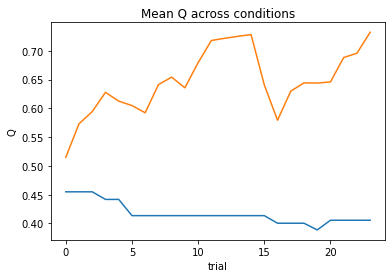

In [7]:
# use one subject (feel free to change)
behavior = subject_data[9] 

# guess for alpha and theta
params = [.12, 2.11] 

# specify subject data
choices = behavior.true_accuracy
outcomes = behavior.outcome
block = behavior.block 

# compute negative log likelihood given
# data and guessed parameters
subj_negll = Simple_1a1t(params, choices, outcomes, block, plot=True)

subject 01: alpha=0.91, theta=3.13; negLL=41.24; BIC=91.60


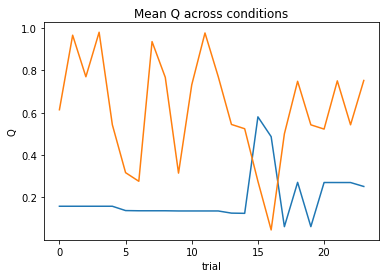

subject 02: alpha=0.03, theta=12.00; negLL=51.42; BIC=111.97


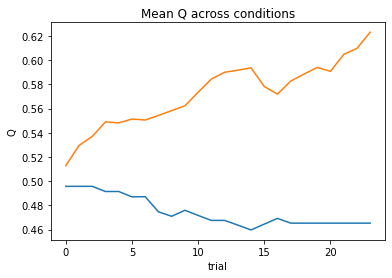

subject 03: alpha=0.06, theta=12.00; negLL=41.13; BIC=91.39


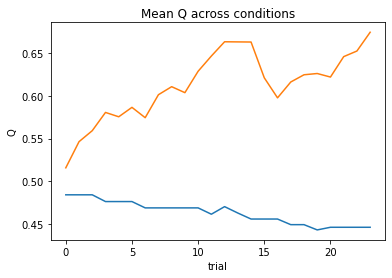

subject 04: alpha=0.00, theta=1.00; negLL=66.54; BIC=142.21


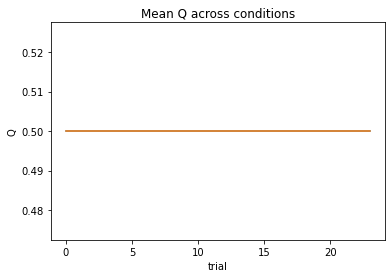

subject 05: alpha=0.23, theta=7.15; negLL=35.25; BIC=79.63


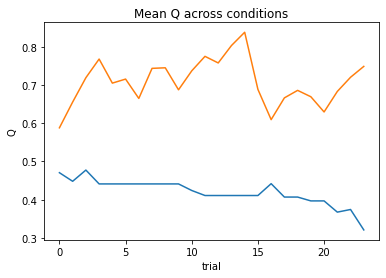

subject 06: alpha=0.44, theta=5.81; negLL=28.37; BIC=65.87


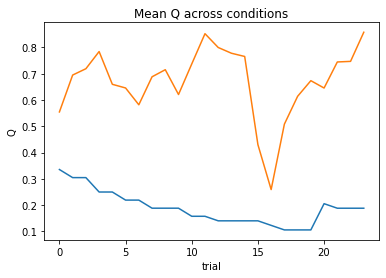

subject 07: alpha=0.13, theta=12.00; negLL=19.16; BIC=47.44


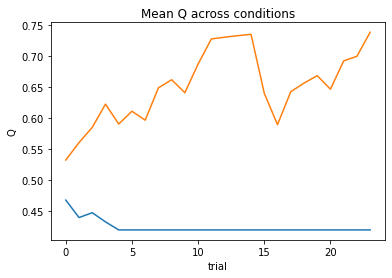

subject 08: alpha=0.16, theta=5.38; negLL=48.77; BIC=106.68


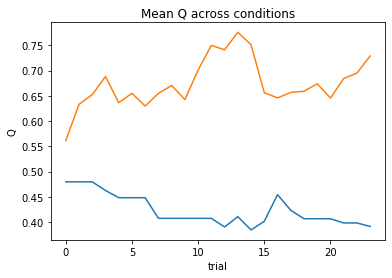

subject 09: alpha=0.31, theta=7.58; negLL=28.84; BIC=66.80


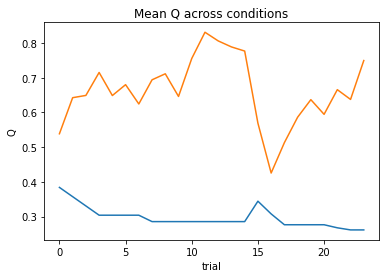

subject 10: alpha=0.31, theta=11.00; negLL=18.06; BIC=45.26


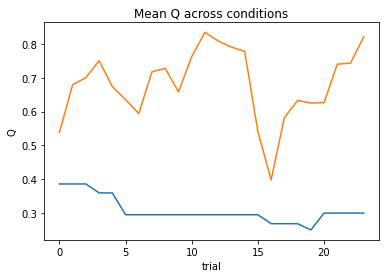

subject 11: alpha=0.25, theta=12.00; negLL=12.57; BIC=34.26


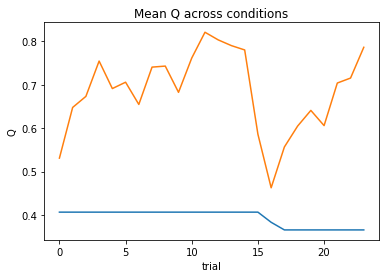

In [8]:
#initialize dataframe to store results
df1 = pd.DataFrame(index=range(11), columns=['alpha','theta','NLL'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_guess in np.linspace(0,1,3):
        for theta_guess in np.linspace(1,12,4):

            # guesses for alpha, theta will change on each loop
            init_guess = (alpha_guess, theta_guess)

            for algorithm in algorithms:

                # minimize neg LL
                result = minimize(Simple_1a1t,
                                  init_guess,
                                  (c, o, block),
                                  bounds=bounds,
                                  method=algorithm)

                # if current negLL is smaller than the last negLL,
                # then store current data
                if result.fun < res_nll and result.success:
                    res_nll = result.fun
                    param_fits = result.x

    # also, compute BIC
    BIC = 2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df1.at[index, 'alpha'] = param_fits[0]
    df1.at[index, 'theta'] = param_fits[1]
    df1.at[index, 'NLL'] = res_nll
    df1.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Simple_1a1t(param_fits, c, o, block, plot=True)

In [9]:
display(df1)

,alpha,theta,NLL,BIC
0,0.910384,3.125691,41.235016,91.598729
1,0.034217,12.0,51.419038,111.966772
2,0.063137,12.0,41.131208,91.391112
3,0.0,1.0,66.542129,142.212955
4,0.234915,7.149005,35.249369,79.627435
5,0.438106,5.812433,28.370059,65.868814
6,0.129681,12.0,19.155706,47.440108
7,0.163722,5.379728,48.774263,106.677222
8,0.30879,7.577299,28.83555,66.799797
9,0.305454,11.001907,18.063611,45.255917


In [10]:
def Social_2a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self + 1 alpha_other + 1 theta
    '''
    Inputs:
        - params: list of 3 guesses (float) for each parameter (alpha_self, alpha_other, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, alpha_other, theta = params 
    
    # check inputs
    if np.isnan(alpha_self) or np.isnan(alpha_other) or np.isnan(theta): 
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if self vs social
            #    Note: this bulky if-statement
            #    is intentional to make it clear
            #    what we are doing
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan 
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'social' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

subject 01: alpha_self=0.76, alpha_other=1.00, theta=3.30; negLL=40.68; BIC=95.06


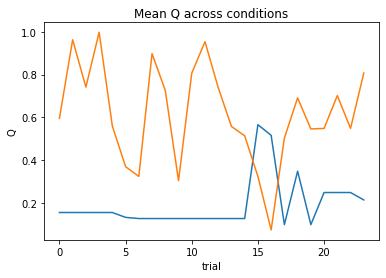

subject 02: alpha_self=0.08, alpha_other=0.02, theta=12.00; negLL=46.42; BIC=106.53


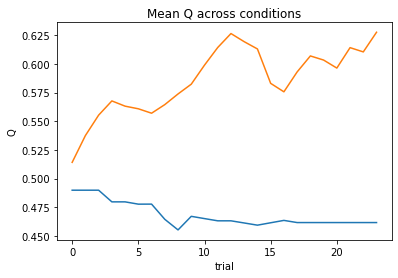

subject 03: alpha_self=0.11, alpha_other=0.04, theta=12.00; negLL=38.84; BIC=91.38


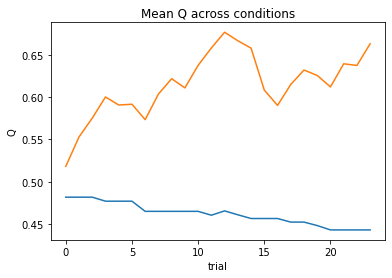

subject 04: alpha_self=0.00, alpha_other=0.00, theta=12.00; negLL=66.41; BIC=146.51


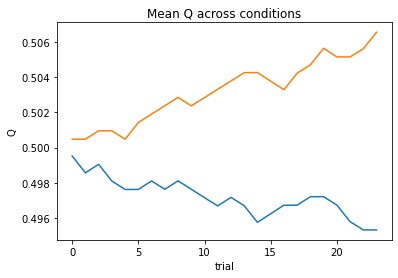

subject 05: alpha_self=0.26, alpha_other=0.18, theta=7.69; negLL=35.02; BIC=83.73


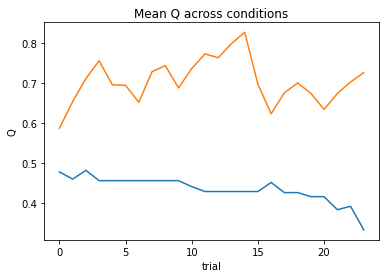

subject 06: alpha_self=0.30, alpha_other=0.65, theta=6.24; negLL=27.35; BIC=68.39


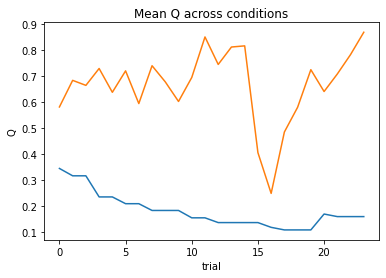

subject 07: alpha_self=0.14, alpha_other=0.12, theta=12.00; negLL=19.08; BIC=51.85


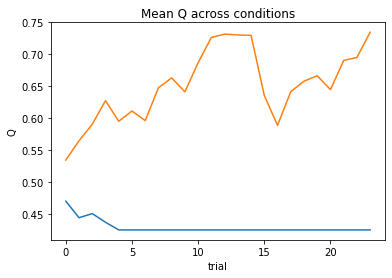

subject 08: alpha_self=0.16, alpha_other=0.69, theta=3.99; negLL=47.11; BIC=107.91


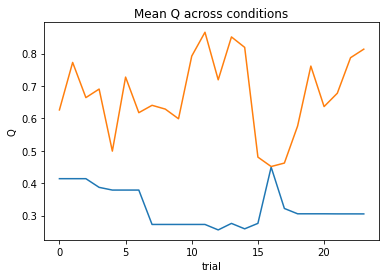

subject 09: alpha_self=0.42, alpha_other=0.24, theta=7.91; negLL=28.21; BIC=70.12


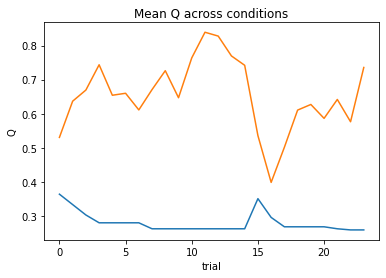

subject 10: alpha_self=0.29, alpha_other=0.80, theta=12.00; negLL=17.71; BIC=49.11


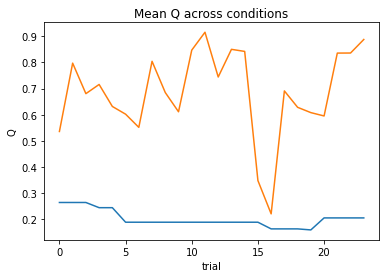

subject 11: alpha_self=0.33, alpha_other=0.20, theta=12.00; negLL=12.02; BIC=37.74


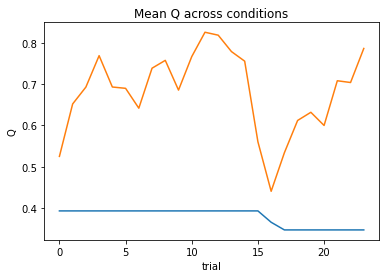

In [11]:
#initialize dataframe to store results
df2 = pd.DataFrame(index=range(11), columns=['alpha','theta','NLL'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_self_guess in np.linspace(0,1,3):
        for alpha_other_guess in np.linspace(0,1,3):
            for theta_guess in np.linspace(1,12,4):

                # guesses for alpha, theta will change on each loop
                init_guess = (alpha_self_guess, alpha_other_guess, theta_guess)

                for algorithm in algorithms:

                    # minimize neg LL
                    result = minimize(Social_2a1t,
                                      init_guess,
                                      (c, o, block),
                                      bounds=bounds,
                                      method=algorithm)

                    # if current negLL is smaller than the last negLL,
                    # then store current data
                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x

    # also, compute BIC
    BIC = 2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df2.at[index, 'alpha'] = param_fits[0]
    df2.at[index, 'theta'] = param_fits[1]
    df2.at[index, 'NLL'] = res_nll
    df2.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha_self={param_fits[0]:.2f}, alpha_other={param_fits[1]:.2f}, theta={param_fits[2]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Social_2a1t(param_fits, c, o, block, plot=True)

In [12]:
display(df2)

,alpha,theta,NLL,BIC
0,0.760689,1.0,40.681883,95.056810
1,0.081382,0.015783,46.417372,106.527788
2,0.107811,0.037979,38.844495,91.382034
3,0.0,0.003832,66.406572,146.506188
4,0.260908,0.175293,35.018243,83.729531
5,0.296518,0.651074,27.348106,68.389257
6,0.139729,0.11758,19.077929,51.848903
7,0.160885,0.688449,47.106963,107.906970
8,0.424338,0.242731,28.212399,70.117842
9,0.285959,0.801353,17.710507,49.114059


In [13]:
# Model 3(12 out of 30 points)
def Valence_2a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_positive + 1 alpha_negative + 1 theta
    '''
    Inputs:
        - params: list of 3 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_positive, alpha_negative, theta = params 
    # check inputs
    if np.isnan(alpha_positive) or np.isnan(alpha_negative) or np.isnan(theta): 
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if positive vs negative
            #    Note: this bulky if-statement
            #    is intentional to make it clear
            #    what we are doing
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan 
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'win' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_positive * delta
                    elif 'avoidloss' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_negative * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

subject 01: alpha_pos=0.65, alpha_neg=1.00, theta=3.63; negLL=40.13; BIC=93.96


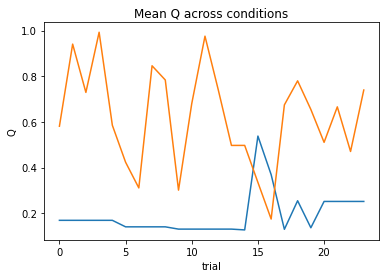

subject 02: alpha_pos=0.04, alpha_neg=0.03, theta=12.00; negLL=51.40; BIC=116.50


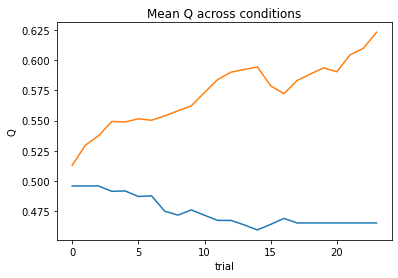

subject 03: alpha_pos=0.14, alpha_neg=0.03, theta=12.00; negLL=36.22; BIC=86.14


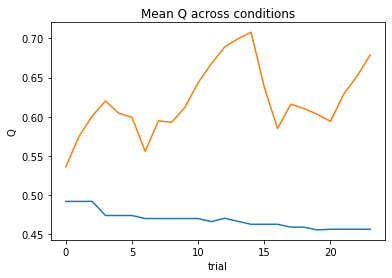

subject 04: alpha_pos=0.00, alpha_neg=0.00, theta=1.00; negLL=66.54; BIC=146.78


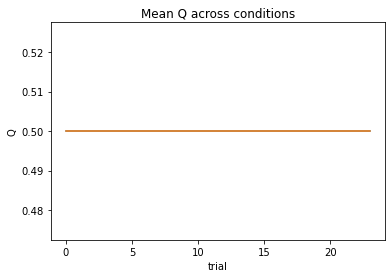

subject 05: alpha_pos=0.21, alpha_neg=0.39, theta=6.86; negLL=34.70; BIC=83.10


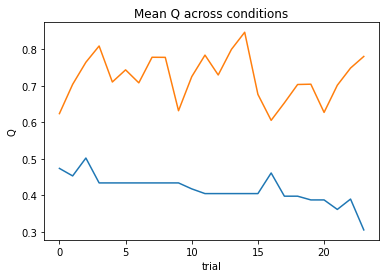

subject 06: alpha_pos=0.25, alpha_neg=0.77, theta=7.09; negLL=26.24; BIC=66.17


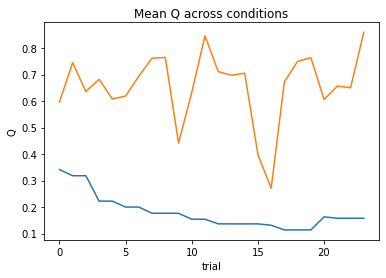

subject 07: alpha_pos=0.14, alpha_neg=0.12, theta=12.00; negLL=19.10; BIC=51.89


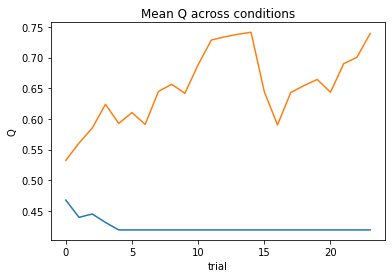

subject 08: alpha_pos=1.00, alpha_neg=0.22, theta=3.18; negLL=46.58; BIC=106.85


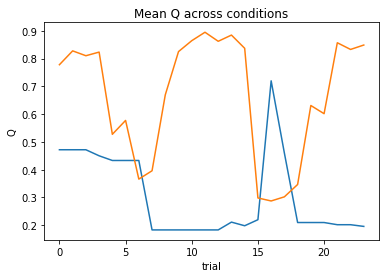

subject 09: alpha_pos=0.19, alpha_neg=0.43, theta=8.11; negLL=27.76; BIC=69.20


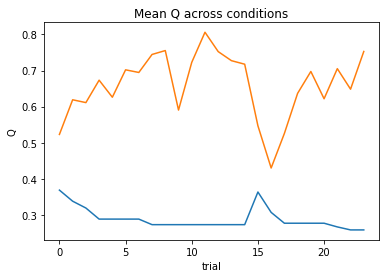

subject 10: alpha_pos=0.24, alpha_neg=0.53, theta=11.22; negLL=17.33; BIC=48.35


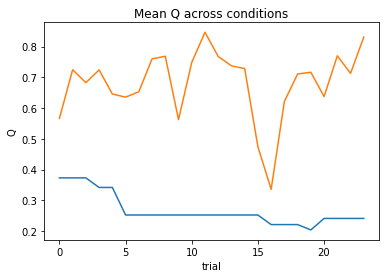

subject 11: alpha_pos=0.26, alpha_neg=0.24, theta=12.00; negLL=12.55; BIC=38.79


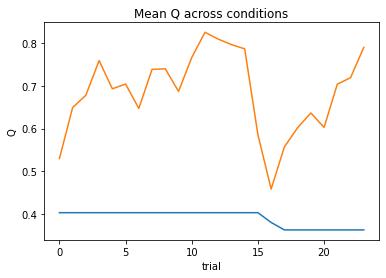

In [14]:
#initialize dataframe to store results
df3 = pd.DataFrame(index=range(11), columns=['alpha_pos','alpha_neg','theta','NLL','BIC'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_pos_guess in np.linspace(0,1,3):
        for alpha_neg_guess in np.linspace(0,1,3):
            for theta_guess in np.linspace(1,12,4):

                # guesses for alpha, theta will change on each loop
                init_guess = (alpha_pos_guess, alpha_neg_guess, theta_guess)

                for algorithm in algorithms:

                    # minimize neg LL
                    result = minimize(Valence_2a1t,
                                      init_guess,
                                      (c, o, block),
                                      bounds=bounds,
                                      method=algorithm)

                    # if current negLL is smaller than the last negLL,
                    # then store current data
                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x

    # also, compute BIC
    BIC = 2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df3.at[index, 'alpha_pos'] = param_fits[0]
    df3.at[index, 'alpha_neg'] = param_fits[1]
    df3.at[index, 'theta'] = param_fits[2]
    df3.at[index, 'NLL'] = res_nll
    df3.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha_pos={param_fits[0]:.2f}, alpha_neg={param_fits[1]:.2f}, theta={param_fits[2]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Valence_2a1t(param_fits, c, o, block, plot=True)

In [15]:
display(df3)

,alpha_pos,alpha_neg,theta,NLL,BIC
0,0.648875,1.0,3.633796,40.134944,93.962933
1,0.035713,0.032702,12.0,51.401781,116.496607
2,0.144034,0.032195,12.0,36.224567,86.142178
3,0.0,0.0,1.0,66.542129,146.777303
4,0.208246,0.391592,6.86147,34.704541,83.102127
5,0.2497,0.76605,7.090218,26.236052,66.165148
6,0.139313,0.119977,12.0,19.098325,51.889695
7,1.0,0.224598,3.181657,46.578693,106.85043
8,0.185241,0.430937,8.112291,27.755787,69.204618
9,0.240672,0.533452,11.220255,17.326881,48.346807


In [16]:
# Model 4 (12 out of 30 points)
def Social_2a2t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self + 1 alpha_other + 1 theta_self + 1 theta_other
    '''
    Inputs:
        - params: list of 4 guesses (float) for each parameter 
                (alpha_self, alpha_other, theta_self, theta_other)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, alpha_other, theta_self, theta_other = params 
    
    # check inputs
    if np.isnan(alpha_self) or np.isnan(alpha_other) or np.isnan(theta_self) or np.isnan(theta_other): 
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if self vs social
            #    Note: this bulky if-statement
            #    is intentional to make it clear
            #    what we are doing
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    if 'self' in condition:
                        ev = np.exp(theta_self*np.array(Q))
                    elif 'social' in condition:
                        ev = np.exp(theta_other*np.array(Q))
                    
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'social' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

subject 01: alpha_self=0.64, alpha_other=1.00, theta_self=4.72, theta_other=2.61; negLL=39.76; BIC=97.78


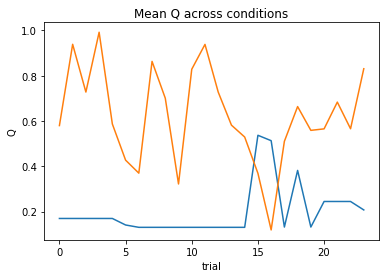

subject 02: alpha_self=0.08, alpha_other=0.02, theta_self=12.00, theta_other=12.00; negLL=46.42; BIC=111.09


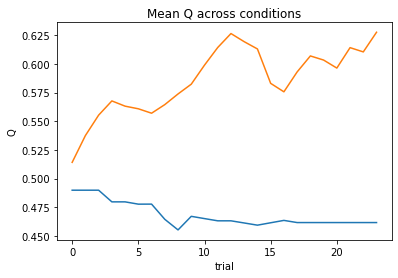

subject 03: alpha_self=0.11, alpha_other=0.46, theta_self=12.00, theta_other=3.21; negLL=37.07; BIC=92.40


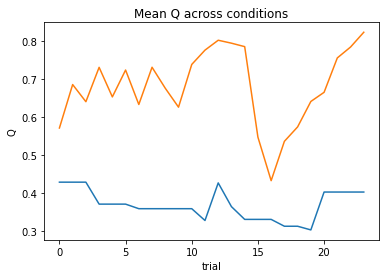

subject 04: alpha_self=0.00, alpha_other=0.00, theta_self=12.00, theta_other=12.00; negLL=66.41; BIC=151.07


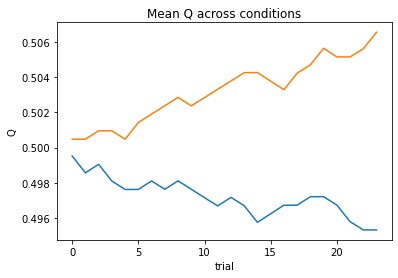

subject 05: alpha_self=0.26, alpha_other=0.20, theta_self=8.13, theta_other=6.87; negLL=34.96; BIC=88.19


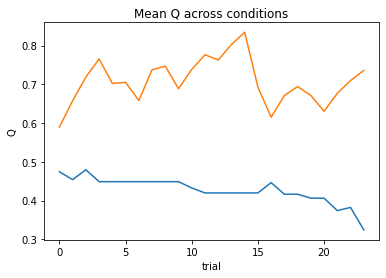

subject 06: alpha_self=0.31, alpha_other=0.65, theta_self=5.98, theta_other=6.47; negLL=27.33; BIC=72.93


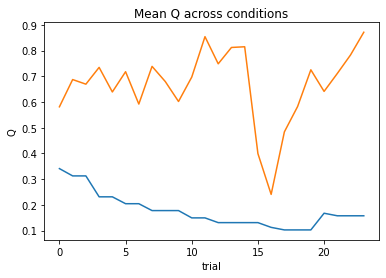

subject 07: alpha_self=0.14, alpha_other=0.12, theta_self=12.00, theta_other=12.00; negLL=19.08; BIC=56.41


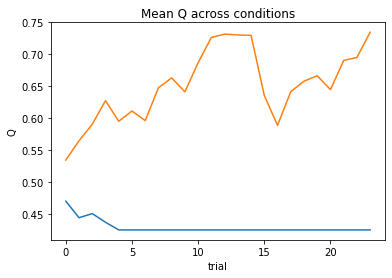

subject 08: alpha_self=0.04, alpha_other=0.78, theta_self=12.00, theta_other=3.13; negLL=45.80; BIC=109.86


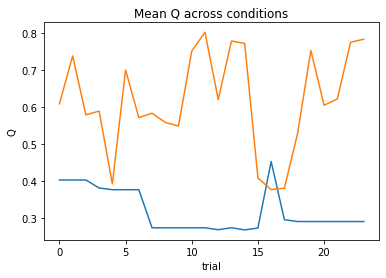

subject 09: alpha_self=0.47, alpha_other=0.19, theta_self=5.21, theta_other=12.00; negLL=24.89; BIC=68.03


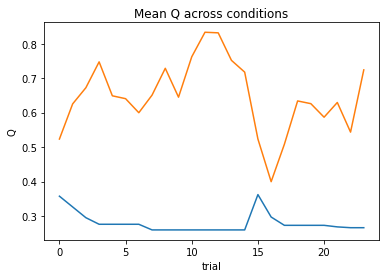

subject 10: alpha_self=0.29, alpha_other=0.56, theta_self=12.00, theta_other=8.34; negLL=17.49; BIC=53.24


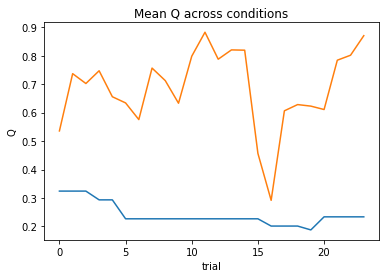

subject 11: alpha_self=0.33, alpha_other=0.20, theta_self=12.00, theta_other=12.00; negLL=12.02; BIC=42.30


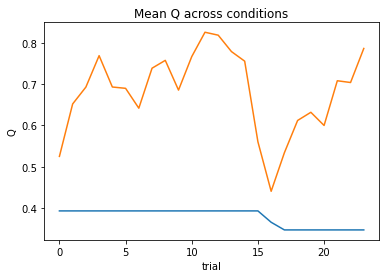

In [17]:
#initialize dataframe to store results
df4 = pd.DataFrame(index=range(11), columns=['alpha_self','alpha_other','theta_self','theta_other','NLL','BIC'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,1),(0,12),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_self_guess in np.linspace(0,1,3):
        for alpha_other_guess in np.linspace(0,1,3):
            for theta_self_guess in np.linspace(1,12,3):
                for theta_other_guess in np.linspace(1,12,3):

                    # guesses for alpha, theta will change on each loop
                    init_guess = (alpha_self_guess, alpha_other_guess, theta_self_guess, theta_other_guess)

                    for algorithm in algorithms:

                        # minimize neg LL
                        result = minimize(Social_2a2t,
                                          init_guess,
                                          (c, o, block),
                                          bounds=bounds,
                                          method=algorithm)

                        # if current negLL is smaller than the last negLL,
                        # then store current data
                        if result.fun < res_nll and result.success:
                            res_nll = result.fun
                            param_fits = result.x

    # also, compute BIC
    BIC = 2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df4.at[index, 'alpha_self'] = param_fits[0]
    df4.at[index, 'alpha_other'] = param_fits[1]
    df4.at[index, 'theta_self'] = param_fits[2]
    df4.at[index, 'theta_other'] = param_fits[3]
    df4.at[index, 'NLL'] = res_nll
    df4.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha_self={param_fits[0]:.2f}, alpha_other={param_fits[1]:.2f}, theta_self={param_fits[2]:.2f}, theta_other={param_fits[3]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Social_2a2t(param_fits, c, o, block, plot=True)

In [18]:
display(df4)

,alpha_self,alpha_other,theta_self,theta_other,NLL,BIC
0,0.64041,1.0,4.719064,2.606712,39.75991,97.777213
1,0.081382,0.015783,12.0,12.0,46.417372,111.092136
2,0.107811,0.462793,12.0,3.211915,37.072458,92.402308
3,0.0,0.003832,12.0,12.0,66.406572,151.070536
4,0.256449,0.204543,8.127817,6.870225,34.964606,88.186605
5,0.310434,0.651042,5.983929,6.46816,27.334393,72.926178
6,0.139729,0.11758,12.0,12.0,19.077929,56.413251
7,0.042555,0.779956,12.0,3.132528,45.800017,109.857427
8,0.474939,0.187772,5.210771,12.0,24.885691,68.028775
9,0.285959,0.559895,12.0,8.336169,17.489508,53.236408


In [19]:
# Bonus Model 5 (not required for exercise)
def SocialValence_4a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self_pos + 1 alpha_self_neg +
    # 1 alpha_other_pos + 1 alpha_other_neg + 1 theta
    '''
    Inputs:
        - params: list of 5 guesses (float) for each parameter 
                    alpha_self_pos
                    alpha_self_neg
                    alpha_other_pos
                    alpha_other_neg
                    theta
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self_pos, alpha_self_neg, alpha_other_pos, alpha_other_neg, theta = params 
    
    # check inputs
    if np.isnan(alpha_self_pos) or np.isnan(alpha_self_neg) or np.isnan(alpha_other_pos) or np.isnan(alpha_other_neg) or np.isnan(theta): 
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]

                    if 'self' in condition:
                        if 'win' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_self_pos * delta
                        elif 'avoidloss' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_self_neg * delta

                    elif 'social' in condition:
                        if 'win' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_other_pos * delta
                        elif 'avoidloss' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_other_neg * delta                    

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

subject 01: alpha_self_pos=0.32, alpha_self_neg=0.98, alpha_other_pos=0.02, alpha_other_neg=1.00, theta=9.44; negLL=38.02; BIC=98.85


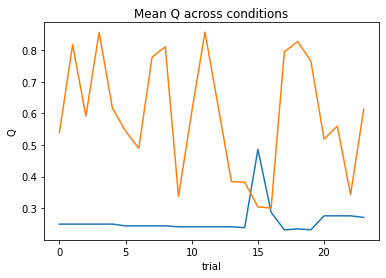

subject 02: alpha_self_pos=0.12, alpha_self_neg=0.07, alpha_other_pos=0.01, alpha_other_neg=0.02, theta=12.00; negLL=46.04; BIC=114.91


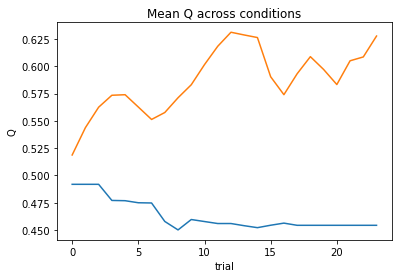

subject 03: alpha_self_pos=0.14, alpha_self_neg=0.08, alpha_other_pos=0.15, alpha_other_neg=0.01, theta=12.00; negLL=33.46; BIC=89.74


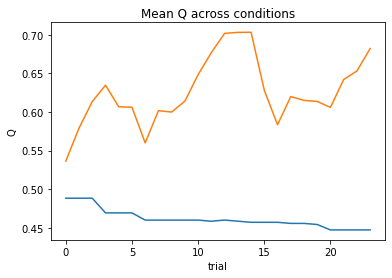

subject 04: alpha_self_pos=0.00, alpha_self_neg=0.00, alpha_other_pos=0.00, alpha_other_neg=0.01, theta=12.00; negLL=66.25; BIC=155.32


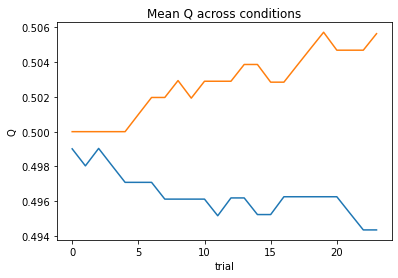

subject 05: alpha_self_pos=0.25, alpha_self_neg=0.32, alpha_other_pos=0.12, alpha_other_neg=0.34, theta=7.99; negLL=34.10; BIC=91.02


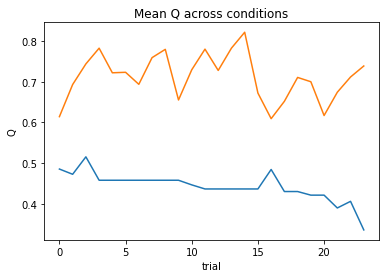

subject 06: alpha_self_pos=0.12, alpha_self_neg=0.63, alpha_other_pos=0.39, alpha_other_neg=0.85, theta=8.01; negLL=25.12; BIC=73.05


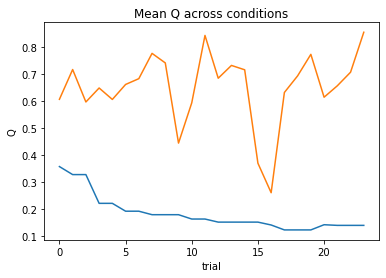

subject 07: alpha_self_pos=0.14, alpha_self_neg=0.14, alpha_other_pos=0.14, alpha_other_neg=0.10, theta=12.00; negLL=18.93; BIC=60.69


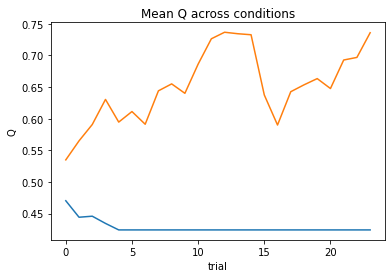

subject 08: alpha_self_pos=0.03, alpha_self_neg=0.14, alpha_other_pos=0.48, alpha_other_neg=0.04, theta=9.78; negLL=44.02; BIC=110.86


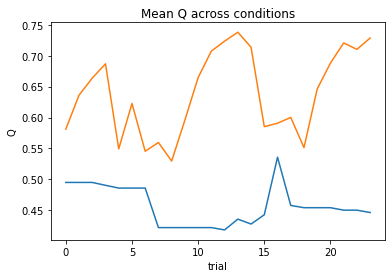

subject 09: alpha_self_pos=0.50, alpha_self_neg=0.38, alpha_other_pos=0.18, alpha_other_neg=0.62, theta=8.13; negLL=26.99; BIC=76.79


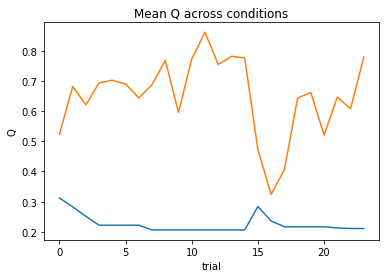

subject 10: alpha_self_pos=0.23, alpha_self_neg=0.56, alpha_other_pos=0.89, alpha_other_neg=0.29, theta=12.00; negLL=16.22; BIC=55.26


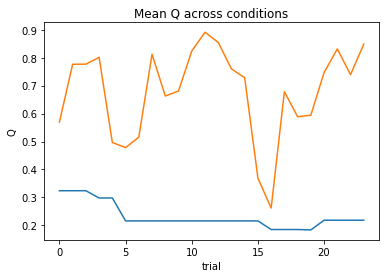

subject 11: alpha_self_pos=0.23, alpha_self_neg=0.40, alpha_other_pos=0.31, alpha_other_neg=0.16, theta=12.00; negLL=11.30; BIC=45.42


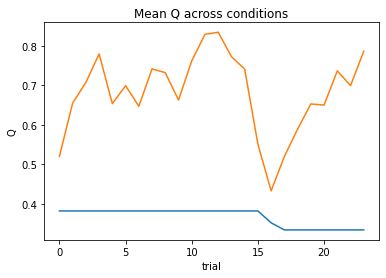

In [20]:
#initialize dataframe to store results
df5 = pd.DataFrame(index=range(11), columns=['alpha_self_pos','alpha_self_neg','alpha_other_pos','alpha_other_neg','theta','NLL','BIC'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,1),(0,1),(0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha, theta
    # (doing less here because the search space is so large!)
    for alpha_self_guess in np.linspace(0,1,3):
        for alpha_other_guess in np.linspace(0,1,3):
            for theta_guess in np.linspace(1,12,3):

                # guesses for alpha, theta will change on each loop
                init_guess = (alpha_self_guess, alpha_other_guess, alpha_self_guess, alpha_other_guess, theta_guess)

                for algorithm in algorithms:

                    # minimize neg LL
                    result = minimize(SocialValence_4a1t,
                                      init_guess,
                                      (c, o, block),
                                      bounds=bounds,
                                      method=algorithm)

                    # if current negLL is smaller than the last negLL,
                    # then store current data
                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x

    # also, compute BIC
    BIC = 2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df5.at[index, 'alpha_self_pos'] = param_fits[0]
    df5.at[index, 'alpha_self_neg'] = param_fits[1]
    df5.at[index, 'alpha_other_pos'] = param_fits[2]
    df5.at[index, 'alpha_other_neg'] = param_fits[3]
    df5.at[index, 'theta'] = param_fits[4]
    df5.at[index, 'NLL'] = res_nll
    df5.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha_self_pos={param_fits[0]:.2f}, alpha_self_neg={param_fits[1]:.2f}, alpha_other_pos={param_fits[2]:.2f}, alpha_other_neg={param_fits[3]:.2f}, theta={param_fits[4]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = SocialValence_4a1t(param_fits, c, o, block, plot=True)

In [21]:
display(df5)

,alpha_self_pos,alpha_self_neg,alpha_other_pos,alpha_other_neg,theta,NLL,BIC
0,0.320348,0.978904,0.023847,1.0,9.437493,38.016359,98.854458
1,0.11808,0.065096,0.014785,0.016731,12.0,46.042017,114.905776
2,0.139103,0.081481,0.152275,0.01182,12.0,33.457502,89.736745
3,0.0,0.0,0.0,0.007885,12.0,66.247088,155.315916
4,0.2519,0.318756,0.116209,0.342456,7.985729,34.10134,91.024422
5,0.116973,0.634377,0.385897,0.849267,8.011112,25.116216,73.054172
6,0.139103,0.140344,0.139586,0.098146,12.0,18.933282,60.688305
7,0.030877,0.139475,0.480044,0.038782,9.780298,44.018283,110.858306
8,0.502454,0.381941,0.184442,0.616257,8.130312,26.986115,76.793971
9,0.226649,0.556591,0.887385,0.294739,12.0,16.218402,55.258546


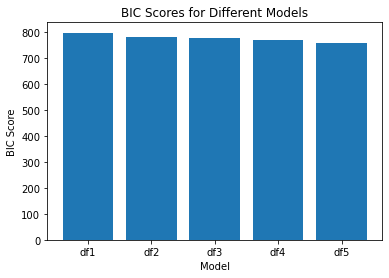

In [22]:
# Compute BIC for each Model and Plot (6 out of 30 points)
def calculate_bic(n, nll, num_params):
    bic = (2 * nll) + (num_params * np.log(n))
    return bic

def plot_bic(list_of_dfs, list_of_num_params, df_names):
    # 96 trials across 11 subjects
    all_num_trials = 96 * 11

    #init list to input bic values
    bic_list = []

    all_mods = list_of_dfs
    all_num_params = list_of_num_params

    # get integrated BIC for each model
    for mod, num_params in zip(all_mods, all_num_params):
        bic_temp = calculate_bic(n=all_num_trials, nll=np.nansum(mod['NLL'].values), num_params=num_params)
        bic_list.append(bic_temp)

    #plot these values:
    plt.bar(range(0,len(all_mods)), bic_list)
    plt.xlabel("Model")
    plt.ylabel("BIC Score")
    plt.title("BIC Scores for Different Models")

    plt.xticks(range(0,len(all_mods)), df_names)
    plt.show()
    
list_of_dfs = [df1, df2, df3, df4, df5]
df_names = ['df1', 'df2', 'df3', 'df4', 'df5']
list_of_num_params = [2, 3, 3, 4, 5]
plot_bic(list_of_dfs, list_of_num_params, df_names)